In [1]:
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import text

from sqlalchemy import create_engine
from urllib.parse import quote_plus


connection_string = (
    'mssql+pyodbc://'
    'Angel_chavez:{}@172.16.2.227\\DWHFARINTERDEV/BI_FARINTER?'
    'driver=ODBC+Driver+17+for+SQL+Server'.format(quote_plus('@ng3l_ch@v3z'))
)
engine = create_engine(connection_string)
query = text("""SELECT
    fc.Suc_Id,
    fc.Emp_Id,
    fc.Caja_Id,
    fc.Factura_Id,
    fc.Factura_Fecha,
    fc.Factura_FechaHora,
    fc.AnioMes_Id,
    fc.Cliente_Id,
    fc.MonederoTarj_Id,
    fc.Vendedor_Id,
    CASE 
        WHEN fc.Monedero_Id = '0' THEN 'No Identificada'
        ELSE md.Tipo_Plan 
    END AS Tipo_Plan,
    md.Edad,
    suc.TipoSucursal_Id,
    suc.TipoSucursal_Nombre,
    suc.Zona_Id,
    suc.Zona_Nombre
FROM
    [BI_Kielsa_Hecho_FacturaEncabezado] AS fc
    JOIN [BI_Kielsa_Dim_Monedero] AS md 
        ON md.Monedero_Id = fc.Monedero_Id AND md.Emp_Id = fc.Emp_Id       
    JOIN [BI_Kielsa_Dim_Sucursal] AS suc 
        ON suc.Sucursal_Id = fc.Suc_Id AND suc.Emp_Id = fc.Emp_Id
WHERE
    fc.AnioMes_Id = 202410 
    AND fc.Emp_Id = 1;""")

with engine.connect() as conn:
    df_base = pd.read_sql(query, conn, index_col='Factura_Id')


In [4]:
df_base.head()

,Suc_Id,Emp_Id,Caja_Id,Factura_Fecha,Factura_FechaHora,AnioMes_Id,Cliente_Id,MonederoTarj_Id,Vendedor_Id,Tipo_Plan,Edad,TipoSucursal_Id,TipoSucursal_Nombre,Zona_Id,Zona_Nombre
Factura_Id,,,,,,,,,,,,,,,
15073,118,1,3,2024-10-26,13:20:38,202410,10000001,0502-1996-01137,10002837,Monedero todo publico,28,8,Supermercado,2,NORTE
119584,56,1,1,2024-10-01,13:11:58,202410,10000001,0502-1996-01177,10003784,Monedero todo publico,28,3,Clínica/Hospitalaria,2,NORTE
17786,268,1,1,2024-10-22,16:26:31,202410,10000001,0502-1996-01178,10004530,Monedero todo publico,28,9,Plaza Comercial,2,NORTE
73545,248,1,4,2024-10-22,17:19:22,202410,10000001,0502-1996-01288,10004684,Monedero todo publico,29,9,Plaza Comercial,2,NORTE
22382,268,1,2,2024-10-30,19:09:34,202410,10000001,0502-1996-01632,10004530,Monedero todo publico,28,9,Plaza Comercial,2,NORTE


In [2]:
print(df_base.columns)

Index(['Suc_Id', 'Emp_Id', 'Caja_Id', 'Factura_Fecha', 'Factura_FechaHora',
       'AnioMes_Id', 'Cliente_Id', 'MonederoTarj_Id', 'Vendedor_Id',
       'Tipo_Plan', 'Edad', 'TipoSucursal_Id', 'TipoSucursal_Nombre',
       'Zona_Id', 'Zona_Nombre'],
      dtype='object')


In [ ]:
df_base.Tipo_Plan.unique()



array(['Monedero todo publico', 'Monedero tercera edad',
       'Monedero Cuarta Edad', 'Club de Médicos', 'Monedero Clínica TE',
       'Monedero Clínica TP', 'No Identificada'], dtype=object)

In [4]:
# Crear una copia del DataFrame original
df = df_base.copy()

# solo tomar la caja 1
df = df[df['Caja_Id'] == 1]

# Convertir los valores de hora a cadenas
df['Factura_FechaHora'] = df['Factura_FechaHora'].astype(str)

# Agregar una fecha ficticia a los valores de hora
df['Factura_FechaHora'] = '1900-01-01 ' + df['Factura_FechaHora']

# Convertir la columna Factura_FechaHora a datetime
df['Factura_FechaHora'] = pd.to_datetime(df['Factura_FechaHora'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Asegúrate de que Factura_Fecha y Factura_FechaHora sean tipo datetime
df['Factura_Fecha'] = pd.to_datetime(df['Factura_Fecha'])

# Crear el diccionario para mapear los tipos de transacciones
tipos_transaccion = {
    'Monedero tercera edad': 'Tercera Edad',
    'Monedero Cuarta Edad': 'Tercera Edad',
    'Monedero todo publico': 'Todo Publico',
    'Monedero Clínica TP': 'Todo Publico',
    'Monedero Clínica TE': 'Tercera Edad',
    'No Identificada': 'No Identificada',
}

print("Cantidad de transacciones por tipo antes de mapear:")
print(df['Tipo_Plan'].value_counts())

# Mapear los tipos de transacciones y eliminar las no relevantes
df['Tipo_Plan'] = df['Tipo_Plan'].map(tipos_transaccion)
df = df.dropna(subset=['Tipo_Plan'])

# Extraer hora y día de la semana para el agrupamiento
df['Hora'] = df['Factura_FechaHora'].dt.hour
df['Dia_Semana'] = df['Factura_Fecha'].dt.day_name()

# Agrupar por sucursal, día de la semana, hora y tipo de transacción
agrupado = df.groupby(['Suc_Id', 'Dia_Semana', 'Hora', 'Tipo_Plan','Factura_Fecha']
                      ).size().reset_index(name='Cantidad_Transacciones')

print("Agrupado:")
print(agrupado.head())


Cantidad de transacciones por tipo antes de mapear:
Tipo_Plan
No Identificada          146320
Monedero todo publico    111266
Monedero tercera edad     57107
Monedero Cuarta Edad       2394
Monedero Clínica TP          10
Monedero Clínica TE           9
Club de Médicos               4
Name: count, dtype: int64
Agrupado:
   Suc_Id Dia_Semana  Hora     Tipo_Plan Factura_Fecha  Cantidad_Transacciones
0       1     Friday    11  Todo Publico    2024-10-18                       2
1       1     Friday    15  Todo Publico    2024-10-18                       1
2       1     Friday    16  Tercera Edad    2024-10-04                       2
3       1     Friday    16  Todo Publico    2024-10-04                       2
4       1     Friday    17  Tercera Edad    2024-10-04                       1


36
Fila con cantidad máxima de transacciones:
       Suc_Id Dia_Semana  Hora        Tipo_Plan Factura_Fecha  \
68843     142   Thursday    12  No Identificada    2024-10-24   
69069     142  Wednesday    12  No Identificada    2024-10-30   

       Cantidad_Transacciones  
68843                      36  
69069                      36  


## Separar los transacciones no identificadas
### Descripción
Dado un conjunto de transacciones identificadas y no identificadas, se desea separar las transacciones no identificadas en dos grupos de acuerdo a la cantidad de transacciones que se pueden identificar con las transacciones identificadas. Para ello, se propone el siguiente algoritmo:
1. Se crea un grafo donde los nodos son las transacciones identificadas y las
aristas son las transacciones que comparten al menos un producto con otra
transacción.
2. Se recorre el grafo y se identifican las componentes conexas.
3. Se asigna cada transacción no identificada a la componente conexa que
comparta más productos con ella.
### Formato de entrada
La entrada consiste de un entero n (1 ≤ n ≤ 100) que indica
la cantidad de transacciones identificadas, seguido de n líneas con las transacciones identificadas. Cada transacción identificada consiste de un entero m (1 ≤ m ≤ 100) que indica la cantidad de


In [10]:
# Filtrar el DataFrame para excluir 'Monedero Farmex Plus' y calcular totales por sucursal y tipo
identificadas = agrupado[agrupado['Tipo_Plan'] != 'No Identificada']
totales_sucursal = identificadas.groupby(['Suc_Id', 'Tipo_Plan'])['Cantidad_Transacciones'].sum().reset_index()
print("Totales por sucursal:")
print(totales_sucursal)


Totales por sucursal:
     Suc_Id     Tipo_Plan  Cantidad_Transacciones
0         1  Tercera Edad                      27
1         1  Todo Publico                     102
2         2  Tercera Edad                      46
3         2  Todo Publico                      83
4         3  Tercera Edad                     500
..      ...           ...                     ...
576     326  Todo Publico                     534
577     327  Tercera Edad                     183
578     327  Todo Publico                     226
579     328  Tercera Edad                      27
580     328  Todo Publico                       9

[581 rows x 3 columns]


In [11]:
# Calcular el total por sucursal
totales_sucursal_total = totales_sucursal.groupby('Suc_Id')['Cantidad_Transacciones'].sum().reset_index()
totales_sucursal_total.rename(columns={'Cantidad_Transacciones': 'Total_Sucursal'}, inplace=True)
# Agregar el total por sucursal al DataFrame
totales_sucursal = totales_sucursal.merge(totales_sucursal_total, on='Suc_Id')

print("Totales por sucursal:")
print(totales_sucursal_total)

Totales por sucursal:
     Suc_Id  Total_Sucursal
0         1             129
1         2             129
2         3            1564
3         4             410
4         5             390
..      ...             ...
286     324             280
287     325             308
288     326             739
289     327             409
290     328              36

[291 rows x 2 columns]


In [12]:
# Calcular proporciones por tipo de transacción en cada sucursal
totales_sucursal['Proporcion'] = (
    totales_sucursal['Cantidad_Transacciones'] / totales_sucursal['Total_Sucursal']
)
print("Proporciones por tipo de transacción:")
print(totales_sucursal)

Proporciones por tipo de transacción:
     Suc_Id     Tipo_Plan  Cantidad_Transacciones  Total_Sucursal  Proporcion
0         1  Tercera Edad                      27             129    0.209302
1         1  Todo Publico                     102             129    0.790698
2         2  Tercera Edad                      46             129    0.356589
3         2  Todo Publico                      83             129    0.643411
4         3  Tercera Edad                     500            1564    0.319693
..      ...           ...                     ...             ...         ...
576     326  Todo Publico                     534             739    0.722598
577     327  Tercera Edad                     183             409    0.447433
578     327  Todo Publico                     226             409    0.552567
579     328  Tercera Edad                      27              36    0.750000
580     328  Todo Publico                       9              36    0.250000

[581 rows x 5 columns]


In [13]:
# Filtrar solo 'Monedero Farmex Plus' para redistribuir
no_identificadas = agrupado[agrupado['Tipo_Plan'] == 'No Identificada']
print("No identificadas:")
print(no_identificadas.count())
# Redistribuir 'Monedero Farmex Plus' según las proporciones
redistribuido = no_identificadas.merge(totales_sucursal[['Suc_Id', 'Tipo_Plan', 'Proporcion']], on='Suc_Id')
redistribuido['Cantidad_Redistribuida'] = (
    redistribuido['Cantidad_Transacciones'] * redistribuido['Proporcion']
)

# Redondear las cantidades redistribuidas
redistribuido['Cantidad_Redistribuida'] = redistribuido['Cantidad_Redistribuida'].round().astype(int)
print("Redistribuido:")
print(redistribuido)


No identificadas:
Suc_Id                    53519
Dia_Semana                53519
Hora                      53519
Tipo_Plan                 53519
Factura_Fecha             53519
Cantidad_Transacciones    53519
dtype: int64
Redistribuido:
        Suc_Id Dia_Semana  Hora      Tipo_Plan_x Factura_Fecha  \
0            1   Saturday    10  No Identificada    2024-10-05   
1            1   Saturday    10  No Identificada    2024-10-05   
2            1   Saturday    10  No Identificada    2024-10-19   
3            1   Saturday    10  No Identificada    2024-10-19   
4            1   Saturday    10  No Identificada    2024-10-26   
...        ...        ...   ...              ...           ...   
107033     328  Wednesday    16  No Identificada    2024-10-23   
107034     328  Wednesday    17  No Identificada    2024-10-09   
107035     328  Wednesday    17  No Identificada    2024-10-09   
107036     328  Wednesday    17  No Identificada    2024-10-23   
107037     328  Wednesday    17  No 

In [14]:
redistribuido.rename(columns={'Cantidad_Redistribuida': 'Cantidad_Transacciones'})
print(redistribuido)

        Suc_Id Dia_Semana  Hora      Tipo_Plan_x Factura_Fecha  \
0            1   Saturday    10  No Identificada    2024-10-05   
1            1   Saturday    10  No Identificada    2024-10-05   
2            1   Saturday    10  No Identificada    2024-10-19   
3            1   Saturday    10  No Identificada    2024-10-19   
4            1   Saturday    10  No Identificada    2024-10-26   
...        ...        ...   ...              ...           ...   
107033     328  Wednesday    16  No Identificada    2024-10-23   
107034     328  Wednesday    17  No Identificada    2024-10-09   
107035     328  Wednesday    17  No Identificada    2024-10-09   
107036     328  Wednesday    17  No Identificada    2024-10-23   
107037     328  Wednesday    17  No Identificada    2024-10-23   

        Cantidad_Transacciones   Tipo_Plan_y  Proporcion  \
0                            1  Tercera Edad    0.209302   
1                            1  Todo Publico    0.790698   
2                          

In [15]:
# Actualizar el DataFrame original con las cantidades redistribuidas
redistribuido = redistribuido[['Suc_Id', 'Tipo_Plan_y', 'Cantidad_Redistribuida']]
redistribuido.rename(columns={'Tipo_Plan_y': 'Tipo_Plan'}, inplace=True)


# Concatenar los datos redistribuidos con los originales sin Farmex
actualizado = pd.concat([
    identificadas,
    redistribuido.rename(columns={'Cantidad_Redistribuida': 'Cantidad_Transacciones'})
])

print("Actualizado:")
print(actualizado)

Actualizado:
        Suc_Id Dia_Semana  Hora     Tipo_Plan Factura_Fecha  \
0            1     Friday  11.0  Todo Publico    2024-10-18   
1            1     Friday  15.0  Todo Publico    2024-10-18   
2            1     Friday  16.0  Tercera Edad    2024-10-04   
3            1     Friday  16.0  Todo Publico    2024-10-04   
4            1     Friday  17.0  Tercera Edad    2024-10-04   
...        ...        ...   ...           ...           ...   
107033     328        NaN   NaN  Todo Publico           NaT   
107034     328        NaN   NaN  Tercera Edad           NaT   
107035     328        NaN   NaN  Todo Publico           NaT   
107036     328        NaN   NaN  Tercera Edad           NaT   
107037     328        NaN   NaN  Todo Publico           NaT   

        Cantidad_Transacciones  
0                            2  
1                            1  
2                            2  
3                            2  
4                            1  
...                        ...  

In [23]:
# Recalcular el pivot para incluir los nuevos valores
pivot_actualizado = actualizado.pivot_table(
    index=['Suc_Id', 'Dia_Semana', 'Hora'],
    columns='Tipo_Plan',
    values='Cantidad_Transacciones',
    fill_value=0
).reset_index()

print(pivot_actualizado)



Tipo_Plan  Suc_Id Dia_Semana  Hora  Tercera Edad  Todo Publico
0               1     Friday  11.0           0.0           2.0
1               1     Friday  15.0           0.0           1.0
2               1     Friday  16.0           2.0           2.0
3               1     Friday  17.0           1.0           1.0
4               1     Friday  21.0           0.0           1.0
...           ...        ...   ...           ...           ...
23138         328  Wednesday  14.0           1.0           0.0
23139         328  Wednesday  15.0           1.0           1.0
23140         328  Wednesday  16.0           1.5           1.5
23141         328  Wednesday  17.0           0.0           1.0
23142         328  Wednesday  18.0           1.0           0.0

[23143 rows x 5 columns]


In [21]:
# Agrupar por sucursal, día de la semana, hora y tipo de transacción
agrupado = df.groupby(['Suc_Id', 'Dia_Semana', 'Hora', 'Tipo_Plan']).size().reset_index(name='Cantidad_Transacciones')

# Pivotear para obtener una columna por tipo de transacción
pivot = agrupado.pivot_table(
    index=['Suc_Id', 'Dia_Semana', 'Hora'], 
    columns='Tipo_Plan', 
    values='Cantidad_Transacciones', 
    fill_value=0
).reset_index()

print(pivot.head())

Tipo_Plan  Suc_Id Dia_Semana  Hora  No Identificada  Tercera Edad  \
0               1     Friday    11                0             0   
1               1     Friday    15                0             0   
2               1     Friday    16                0             2   
3               1     Friday    17                0             1   
4               1     Friday    21                0             0   

Tipo_Plan  Todo Publico  
0                     2  
1                     1  
2                     2  
3                     1  
4                     2  


In [18]:
# cantidad de filas
print(pivot_actualizado.shape[0])

23143


In [24]:
import numpy as np
tiempos_transaccion = {
    'Todo Publico': 5.34,  # Minutos
    'Tercera Edad': 8.13
}

pivot_actualizado['Tiempo_Total'] = (
    pivot_actualizado['Todo Publico'] * tiempos_transaccion['Todo Publico'] +
    pivot_actualizado['Tercera Edad'] * tiempos_transaccion['Tercera Edad']
)

pivot_actualizado['Personal_Necesario'] = np.ceil(pivot_actualizado['Tiempo_Total'] / 42)

# Columnas a guardar en el csv [Suc_Id, Dia_Semana(en numero de 1 a 7), Hora, Transacciones totales, Personal_Necesario]
pivot_actualizado['Dia_Semana'] = pivot_actualizado['Dia_Semana'].map({
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
})
pivot_actualizado['Transacciones_Totales'] = pivot_actualizado['Todo Publico'] + pivot_actualizado['Tercera Edad']
print(pivot_actualizado)


Tipo_Plan  Suc_Id  Dia_Semana  Hora  Tercera Edad  Todo Publico  Tiempo_Total  \
0               1           5  11.0           0.0           2.0        10.680   
1               1           5  15.0           0.0           1.0         5.340   
2               1           5  16.0           2.0           2.0        26.940   
3               1           5  17.0           1.0           1.0        13.470   
4               1           5  21.0           0.0           1.0         5.340   
...           ...         ...   ...           ...           ...           ...   
23138         328           3  14.0           1.0           0.0         8.130   
23139         328           3  15.0           1.0           1.0        13.470   
23140         328           3  16.0           1.5           1.5        20.205   
23141         328           3  17.0           0.0           1.0         5.340   
23142         328           3  18.0           1.0           0.0         8.130   

Tipo_Plan  Personal_Necesar

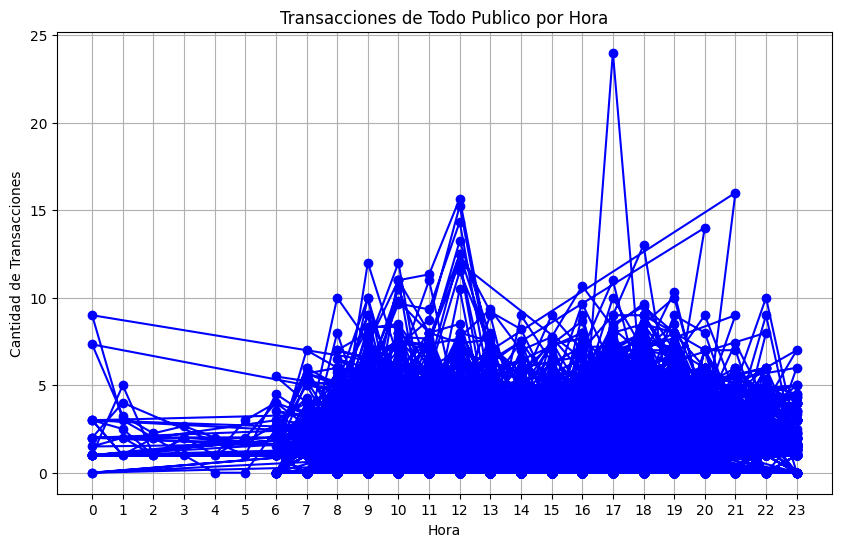

In [38]:
import matplotlib.pyplot as plt

# Asegúrate de que el DataFrame pivot_actualizado esté disponible
# pivot_actualizado = ...

# Graficar los datos de la columna "Todo Publico"
plt.figure(figsize=(10, 6))
plt.plot(pivot_actualizado['Hora'], pivot_actualizado['Todo Publico'], marker='o', linestyle='-', color='b')
plt.title('Transacciones de Todo Publico por Hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de Transacciones')
plt.grid(True)
plt.xticks(range(0, 24))  # Asegurarse de que todas las horas estén en el eje x
plt.show()

## Tiempos promedios
- 8.13 minutos para tercera edad
- 11 minutos para KIELSA CLINICA TP

In [ ]:
## 